In [1]:
import pandas as pd
import numpy as np
import spacy 
from spacy import displacy
import networkx as nx 
import matplotlib.pyplot as plt

In [2]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# load the spacy English language model 
NER = spacy.load("en_core_web_sm")

## Load Novels 

In [4]:
import os 
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

In [5]:
all_books

[<DirEntry '2 The Adventures of Sherlock Holmes.txt'>,
 <DirEntry '9 The Hound of the Baskervilles.txt'>,
 <DirEntry '5 The Valley of Fear.txt'>,
 <DirEntry '8 His Last Bow.txt'>,
 <DirEntry '6 The Memoirs of Sherlock Holmes.txt'>,
 <DirEntry '3 The Sign of the Four.txt'>,
 <DirEntry '4 The Case-Book of Sherlock Holmes.txt'>,
 <DirEntry '1 A Study in Scarlet.txt'>,
 <DirEntry '7 The Return of Sherlock Holmes.txt'>]

In [6]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

In [7]:
# displacy.render(book_doct[0:5000], style="ent", jupyter="True")

## Load Characters 

In [8]:
character_df_raw = pd.read_csv('characters.csv')

In [9]:
character_df_raw.head(10)

,Unnamed: 0,book,character
0,0,A Study in Scarlet,Enoch Drebber
1,1,A Study in Scarlet,John Ferrier
2,2,A Study in Scarlet,Lucy Ferrier
3,3,A Study in Scarlet,Jefferson Hope
4,4,A Study in Scarlet,Edgar Allan Poe
5,5,A Study in Scarlet,Joseph Stangerson
6,6,A Study in Scarlet,Brigham Young
7,7,A Study in Scarlet,Sherlock Holmes
8,8,A Study in Scarlet,John Waston
9,9,The Adventures of Sherlock Holmes,Irene Adler


In [10]:
character_df_raw.insert(0, 'New_ID', range(880, 880 + len(character_df_raw)))
character_df_raw

,New_ID,Unnamed: 0,book,character
0,880,0,A Study in Scarlet,Enoch Drebber
1,881,1,A Study in Scarlet,John Ferrier
2,882,2,A Study in Scarlet,Lucy Ferrier
3,883,3,A Study in Scarlet,Jefferson Hope
4,884,4,A Study in Scarlet,Edgar Allan Poe
...,...,...,...,...
191,1071,191,The Return of Sherlock Holmes,Abe Slaney
192,1072,192,The Return of Sherlock Holmes,James Walter
193,1073,193,The Return of Sherlock Holmes,Williamson
194,1074,194,The Return of Sherlock Holmes,Sherlock Holmes


In [11]:
character_df_raw['character_firstname'] = character_df_raw['character'].apply(lambda x: x.split(' ', 1)[0])

In [12]:
character_df_raw.head(10)

,New_ID,Unnamed: 0,book,character,character_firstname
0,880,0,A Study in Scarlet,Enoch Drebber,Enoch
1,881,1,A Study in Scarlet,John Ferrier,John
2,882,2,A Study in Scarlet,Lucy Ferrier,Lucy
3,883,3,A Study in Scarlet,Jefferson Hope,Jefferson
4,884,4,A Study in Scarlet,Edgar Allan Poe,Edgar
5,885,5,A Study in Scarlet,Joseph Stangerson,Joseph
6,886,6,A Study in Scarlet,Brigham Young,Brigham
7,887,7,A Study in Scarlet,Sherlock Holmes,Sherlock
8,888,8,A Study in Scarlet,John Waston,John
9,889,9,The Adventures of Sherlock Holmes,Irene Adler,Irene


In [13]:
import re
df_temp1 = (character_df_raw['character'].str
                 .split(' ',expand = True)
                 .rename(columns = {0:'character_firstname',1:'character_lastname', 2: "Two", 3:"Three", 4: "Four"}))

In [14]:
df_temp1.head()

,character_firstname,character_lastname,Two,Three,Four
0,Enoch,Drebber,None,None,None
1,John,Ferrier,None,None,None
2,Lucy,Ferrier,None,None,None
3,Jefferson,Hope,None,None,None
4,Edgar,Allan,Poe,None,None


In [15]:
df_temp1 = df_temp1.drop(['character_firstname','Two', 'Three', 'Four'], axis = 1)

In [16]:
df_temp1.insert(0, 'New_ID', range(880, 880 + len(df_temp1)))
df_temp1.head()

,New_ID,character_lastname
0,880,Drebber
1,881,Ferrier
2,882,Ferrier
3,883,Hope
4,884,Allan


In [17]:
df_temp1.isnull().sum()

New_ID                 0
character_lastname    12
dtype: int64

In [18]:
character_df = pd.merge(character_df_raw, df_temp1, how='outer', on='New_ID')

In [19]:
pd.set_option('display.max_rows', None)
character_df.head()

,New_ID,Unnamed: 0,book,character,character_firstname,character_lastname
0,880,0,A Study in Scarlet,Enoch Drebber,Enoch,Drebber
1,881,1,A Study in Scarlet,John Ferrier,John,Ferrier
2,882,2,A Study in Scarlet,Lucy Ferrier,Lucy,Ferrier
3,883,3,A Study in Scarlet,Jefferson Hope,Jefferson,Hope
4,884,4,A Study in Scarlet,Edgar Allan Poe,Edgar,Allan


In [20]:
character_df = character_df.drop(['Unnamed: 0'], axis = 1)

In [21]:
len(character_df)

196

## Get Names Per Sentences 

In [22]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [23]:
sent_entity_df

,sentence,entities
0,"(Chapter, 1, \n\n, Mr., Sherlock, Holmes, \n\n...","[Chapter 1, Sherlock Holmes, Sherlock Holmes]"
1,"(I, stood, upon, the, \n, hearth, -, rug, and,...",[the night before]
2,"(It, was, a, fine, ,, thick, piece, of, wood, ...",[Penang]
3,"("", \n, Just, under, the, head, was, a, broad,...",[]
4,"("", To, James, Mortimer, ,, M.R.C.S., ,, from,...","[James Mortimer, M.R.C.S., C.C.H., 1884]"
5,"(It, was, just, \n, such, a, stick, as, the, o...",[]
6,"("", Well, ,, Watson, ,, what, do, you, make, o...","[Well,, Watson]"
7,"("", \n\n, Holmes, was, sitting, with, his, bac...",[Holmes]
8,"("", How, did, you, know, what, I, was, doing, ?)",[]
9,"(I, believe, you, have, eyes, in, \n, the, bac...",[]


In [24]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_lastname)]

In [25]:
filter_entity(["Holmes", "An", "2"], character_df)

['Holmes']

In [26]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
0,"(Chapter, 1, \n\n, Mr., Sherlock, Holmes, \n\n...","[Chapter 1, Sherlock Holmes, Sherlock Holmes]","[Sherlock Holmes, Sherlock Holmes]"
4,"("", To, James, Mortimer, ,, M.R.C.S., ,, from,...","[James Mortimer, M.R.C.S., C.C.H., 1884]",[James Mortimer]
6,"("", Well, ,, Watson, ,, what, do, you, make, o...","[Well,, Watson]",[Watson]
7,"("", \n\n, Holmes, was, sitting, with, his, bac...",[Holmes],[Holmes]
11,"("", But, ,, tell, me, ,, Watson, ,, what, do, ...",[Watson],[Watson]
14,"("", \n\n, "", I, think, ,, "", said, I, ,, follo...",[Mortimer],[Mortimer]
15,"("", \n\n, "", Good, !, "", said, Holmes, .)",[Holmes],[Holmes]
19,"("", \n\n, "", Perfectly, sound, !, "", said, Hol...",[Holmes],[Holmes]
21,"("", \n\n, "", Really, ,, Watson, ,, you, excel,...","[Really, Watson, Holmes]",[Holmes]
36,"("", \n\n, "", I, am, afraid, ,, my, dear, Watso...",[Watson],[Watson]


In [27]:

# Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

/var/folders/g2/tz8mrjyx0bd21mkwkqx_jn840000gn/T/ipykernel_23794/458370115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [28]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
0,"(Chapter, 1, \n\n, Mr., Sherlock, Holmes, \n\n...","[Chapter 1, Sherlock Holmes, Sherlock Holmes]","[Sherlock, Sherlock]"
4,"("", To, James, Mortimer, ,, M.R.C.S., ,, from,...","[James Mortimer, M.R.C.S., C.C.H., 1884]",[James]
6,"("", Well, ,, Watson, ,, what, do, you, make, o...","[Well,, Watson]",[Watson]
7,"("", \n\n, Holmes, was, sitting, with, his, bac...",[Holmes],[Holmes]
11,"("", But, ,, tell, me, ,, Watson, ,, what, do, ...",[Watson],[Watson]
...,...,...,...
3430,"(Stapleton, himself, seems, to, have, \n, been...",[Stapleton],[Stapleton]
3439,"(And, now, ,, my, dear, Watson, ,, without, re...",[Watson],[Watson]
3446,"(If, Stapleton, came, \n, into, the, successio...",[Stapleton],[Stapleton]
3449,"(Mrs., Stapleton, has, heard, her, \n, husband...",[Stapleton],[Stapleton]


## Create relationships

In [29]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [30]:
relationship_df = pd.DataFrame(relationships)

In [31]:
pd.set_option('display.max_rows', None)
relationship_df

,source,target
0,Sherlock,James
1,James,Watson
2,James,Watson
3,Watson,Holmes
4,James,Watson
5,Watson,Holmes
6,James,Watson
7,Watson,Holmes
8,Watson,Holmes
9,Watson,Holmes


In [32]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,James,Sherlock
1,James,Watson
2,James,Watson
3,Holmes,Watson
4,James,Watson
5,Holmes,Watson
6,James,Watson
7,Holmes,Watson
8,Holmes,Watson
9,Holmes,Watson


In [33]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [34]:

relationship_df.head(10)

,source,target,value
0,James,Sherlock,1
1,James,Watson,9
2,Holmes,Watson,134
3,Mortimer,Watson,42
4,Holmes,Mortimer,137
5,Sherlock,Watson,53
6,Mortimer,Sherlock,23
7,James,Mortimer,13
8,Holmes,James,16
9,Holmes,Sherlock,10


## Graph analysis and visualization

In [35]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

### Graph visualization - Networkx

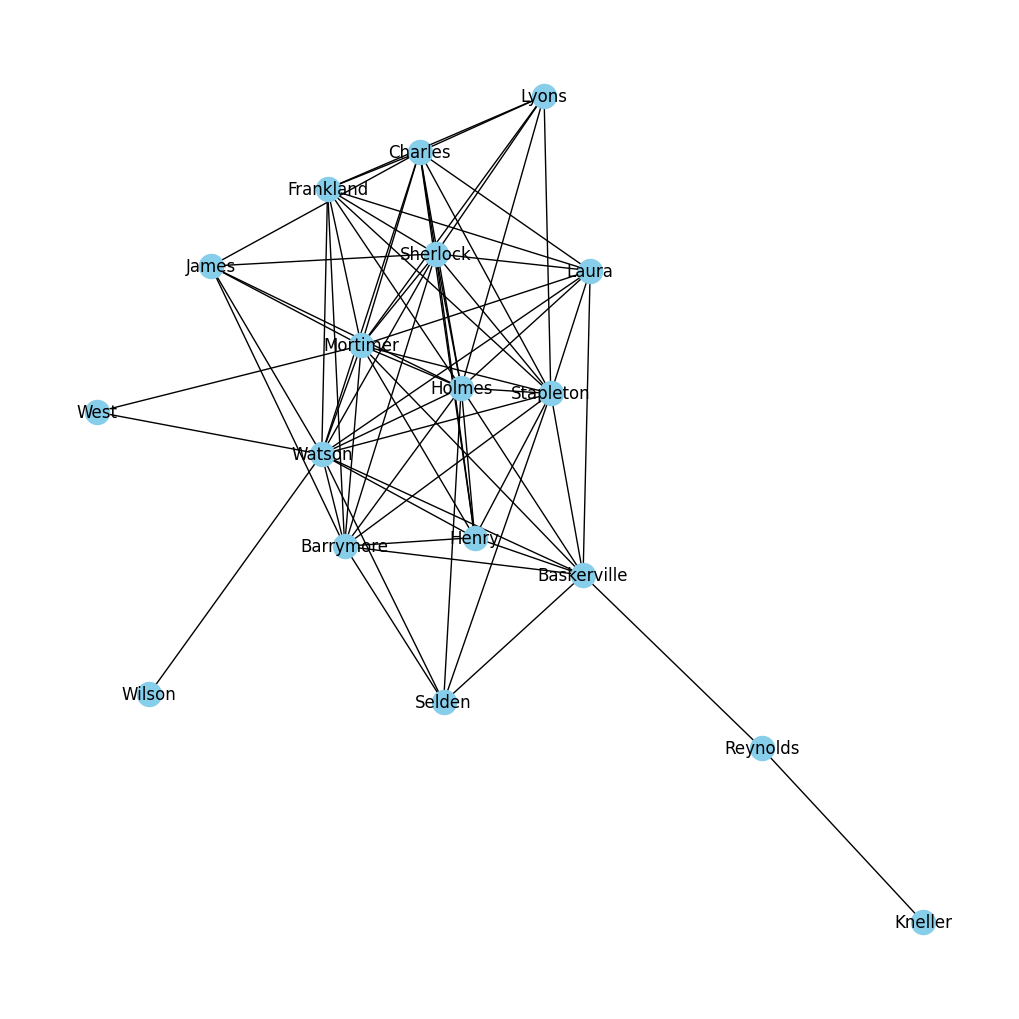

In [36]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Graph visualization - Pyvis

In [37]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("holmes.html")

holmes.html


## The most important characters in the book: The Hound of the Baskervilles

In [38]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'James': 0.3529411764705882,
 'Sherlock': 0.6470588235294118,
 'Watson': 0.8235294117647058,
 'Holmes': 0.7647058823529411,
 'Mortimer': 0.7647058823529411,
 'Charles': 0.5882352941176471,
 'Baskerville': 0.5294117647058824,
 'Barrymore': 0.5882352941176471,
 'Henry': 0.47058823529411764,
 'Frankland': 0.5294117647058824,
 'Stapleton': 0.7058823529411764,
 'West': 0.11764705882352941,
 'Wilson': 0.058823529411764705,
 'Selden': 0.29411764705882354,
 'Laura': 0.47058823529411764,
 'Lyons': 0.3529411764705882,
 'Kneller': 0.058823529411764705,
 'Reynolds': 0.11764705882352941}

<Axes: >

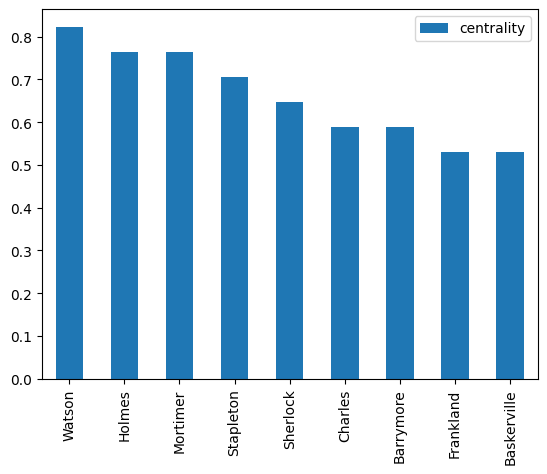

In [39]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

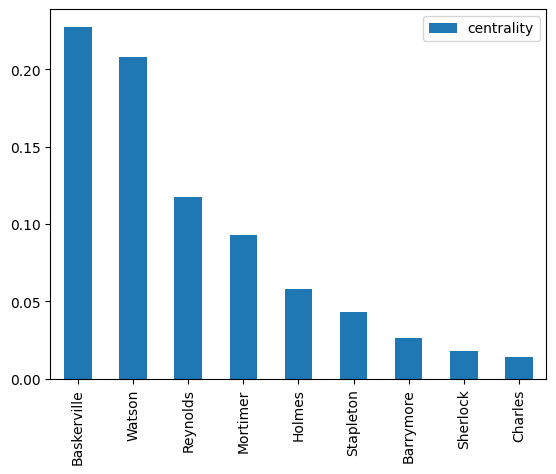

In [40]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

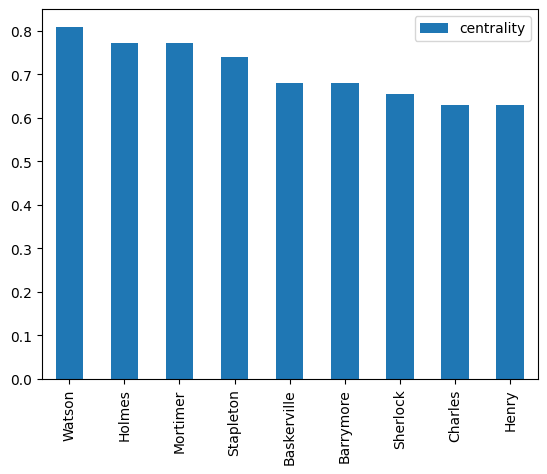

In [41]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [42]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

## Evolution of characters' importance

In [43]:
from lib.utils.functions import *

In [44]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [45]:

# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)
# Loop through book list and create graphs
for book in all_books:
    book_text = ner(book)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

/var/folders/g2/tz8mrjyx0bd21mkwkqx_jn840000gn/T/ipykernel_23794/2843047473.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
/var/folders/g2/tz8mrjyx0bd21mkwkqx_jn840000gn/T/ipykernel_23794/2843047473.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


<Axes: >

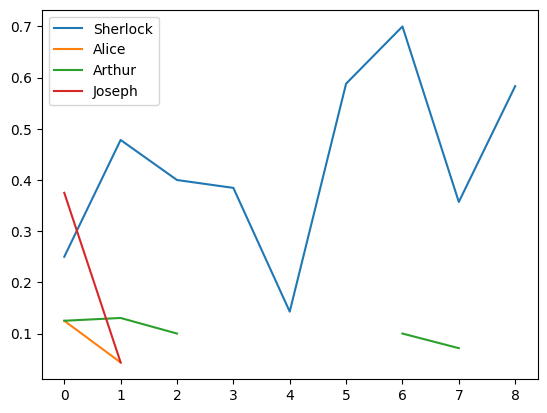

In [71]:

# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Sherlock", "Alice", "Arthur", "Joseph"]].plot()

In [65]:
degree_evol_df

,Alice,Arthur,Joseph,Sherlock,Jefferson,Enoch,John,Lucy,Brigham,Irene,...,Louis,Culverton,Von,Heinrich,Baskerville,Rodger,Frankland,Eliza,Selden,Laura
0,0.125000,0.125000,0.375000,0.250000,0.5,0.375,0.500000,0.375000,0.125,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.043478,0.130435,0.043478,0.478261,NaN,NaN,0.086957,0.043478,NaN,0.130435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.100000,NaN,0.400000,0.1,NaN,0.100000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.384615,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.117647,0.588235,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,0.100000,NaN,0.700000,NaN,NaN,0.050000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,0.071429,NaN,0.357143,NaN,NaN,0.071429,NaN,NaN,0.142857,...,0.071429,0.071429,0.357143,0.142857,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,0.583333,NaN,NaN,0.250000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.583333,0.25,0.416667,0.083333,0.083333,0.5
